### Prueba de implementación de WeatherBenchX

In [1]:
import os

src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(src_path)

from src.seacast_tools.np_loaders import TargetsFromNumpy, PredictionsFromNumpy
from weatherbenchX.metrics import deterministic, probabilistic
from weatherbenchX.metrics import base as metrics_base
from weatherbenchX import aggregation


### Carga de datos de test

In [2]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]

targets = TargetsFromNumpy(
    path=directory,
    variables=variables,
    extra_variables=extra_variables,
    extra_files=extra_files
)

Loaded 1 data entries from data\atlantic\samples\test


In [3]:
targets_dataset = targets.load_chunk()

targets_dataset

<xarray.Dataset> Size: 4MB
Dimensions:          (latitude: 300, longitude: 300, init_time: 1, lead_time: 15)
Coordinates:
  * latitude         (latitude) float64 2kB 19.57 19.62 19.68 ... 34.48 34.52
  * longitude        (longitude) float64 2kB -20.93 -20.88 ... -6.025 -5.975
  * init_time        (init_time) datetime64[ns] 8B 2022-01-02
  * lead_time        (lead_time) timedelta64[ns] 120B 1 days 2 days ... 15 days
    mask             (init_time, lead_time, latitude, longitude) bool 1MB Tru...
    valid_time       (init_time, lead_time) datetime64[ns] 120B 2022-01-03 .....
Data variables:
    sst_temperature  (init_time, lead_time, latitude, longitude) float16 3MB ...

### Carga de datos de predicción

In [4]:
directory = r"data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_173928-gbp74pck\files\predictions"

pred_loader = PredictionsFromNumpy(
    path=directory,
    variables=variables,
    extra_variables=extra_variables,
    extra_files=extra_files
)

predictions_dataset = pred_loader.load_chunk()

Loaded 1 data entries from data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_173928-gbp74pck\files\predictions


In [5]:
predictions_dataset

<xarray.Dataset> Size: 4MB
Dimensions:          (latitude: 300, longitude: 300, init_time: 1, lead_time: 15)
Coordinates:
  * latitude         (latitude) float64 2kB 19.57 19.62 19.68 ... 34.48 34.52
  * longitude        (longitude) float64 2kB -20.93 -20.88 ... -6.025 -5.975
  * init_time        (init_time) datetime64[ns] 8B 2022-01-02
  * lead_time        (lead_time) timedelta64[ns] 120B 1 days 2 days ... 15 days
    mask             (init_time, lead_time, latitude, longitude) bool 1MB Tru...
Data variables:
    sst_temperature  (init_time, lead_time, latitude, longitude) float16 3MB ...

In [6]:
metrics = {
  'rmse': deterministic.RMSE(),
  'mae': deterministic.MAE(),
}
metrics['rmse'].statistics

{'SquaredError': <weatherbenchX.metrics.deterministic.SquaredError at 0x142921ca560>}

### Cálculo de estadísticas

In [7]:
statistics = metrics_base.compute_unique_statistics_for_all_metrics(
  metrics, predictions_dataset, targets_dataset
)

In [8]:
aggregator = aggregation.Aggregator(
  reduce_dims=["lead_time"], skipna=True
)

aggregation_state = aggregator.aggregate_statistics(statistics)

aggregation_state

AggregationState(sum_weighted_statistics={'SquaredError': {'sst_temperature': <xarray.DataArray 'sst_temperature' (init_time: 1, latitude: 300, longitude: 300)> Size: 180kB
array([[[ 2.125 ,  1.6875,  1.0625, ...,  0.    ,  0.    ,  0.    ],
        [ 0.8125,  1.875 ,  2.188 , ...,  0.    ,  0.    ,  0.    ],
        [10.625 ,  5.562 ,  8.625 , ...,  0.    ,  0.    ,  0.    ],
        ...,
        [ 3.5   ,  0.8125,  1.625 , ...,  0.    ,  0.    ,  0.    ],
        [ 1.75  ,  3.375 ,  1.6875, ...,  0.    ,  0.    ,  0.    ],
        [ 1.6875,  0.5625,  0.4375, ...,  0.    ,  0.    ,  0.    ]]],
      dtype=float16)
Coordinates:
  * latitude   (latitude) float64 2kB 19.57 19.62 19.68 ... 34.42 34.48 34.52
  * longitude  (longitude) float64 2kB -20.93 -20.88 -20.82 ... -6.025 -5.975
  * init_time  (init_time) datetime64[ns] 8B 2022-01-02}, 'AbsoluteError': {'sst_temperature': <xarray.DataArray 'sst_temperature' (init_time: 1, latitude: 300, longitude: 300)> Size: 180kB
array([[[ 5.  ,  4

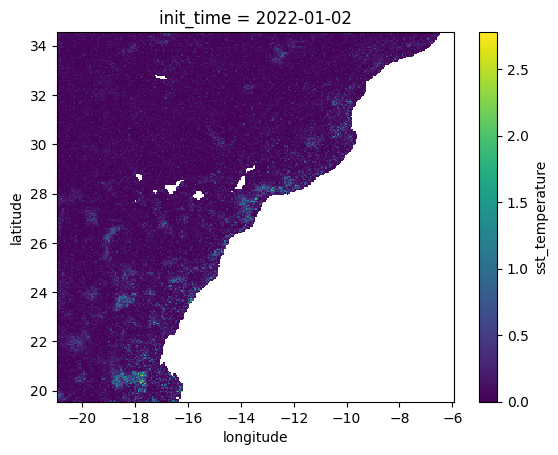

In [9]:
aggregation_state.mean_statistics()['SquaredError']['sst_temperature'].isel(init_time=0).plot()

### Prueba ensemble DataLoader

In [10]:
def get_ensemble_dataset_loaders(directories):
  
    loaders = []
    for directory in directories:
        predictions = PredictionsFromNumpy(
            path=directory,
            variables=variables,
            extra_variables=extra_variables,
            extra_files=extra_files
        )
        loaders.append(predictions)
    
    return loaders

In [11]:
from src.seacast_tools.ensemble_loaders import EnsembleFromNpLoaders

variables = ["sst_temperature"]
directories = [r"data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_173928-gbp74pck\files\predictions", r"data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_174214-r2ek9l48\files\predictions", r"data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_174506-wbt22vo4\files\predictions", r"data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_174831-3y0kvpx8\files\predictions",r"data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_175100-02dtpyi1\files\predictions"]


extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]

targets = TargetsFromNumpy(
    path=directory,
    variables=variables,
    extra_variables=extra_variables,
    extra_files=extra_files
)

data_loaders = get_ensemble_dataset_loaders(directories)

pred_loader = EnsembleFromNpLoaders(loaders=data_loaders)

predictions_dataset = pred_loader.build_ensemble()

Loaded 1 data entries from data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_173928-gbp74pck\files\predictions
Loaded 1 data entries from data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_173928-gbp74pck\files\predictions
Loaded 1 data entries from data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_174214-r2ek9l48\files\predictions
Loaded 1 data entries from data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_174506-wbt22vo4\files\predictions
Loaded 1 data entries from data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_174831-3y0kvpx8\files\predictions
Loaded 1 data entries from data\atlantic\predictions mock\ensemble_5\gaussian_01\run-20250623_175100-02dtpyi1\files\predictions


In [12]:
metrics = {
    "crps" : probabilistic.CRPSEnsemble(),
    "rmse_unb": probabilistic.UnbiasedEnsembleMeanRMSE(skipna_ensemble=True),
    "spread_skill_ratio": probabilistic.SpreadSkillRatio(skipna_ensemble=True),
    "spread_skill_ratio_unb": probabilistic.UnbiasedSpreadSkillRatio(skipna_ensemble=True),
}

In [13]:
predictions_dataset

<xarray.Dataset> Size: 15MB
Dimensions:          (number: 5, init_time: 1, lead_time: 15, latitude: 300,
                      longitude: 300)
Coordinates:
  * latitude         (latitude) float64 2kB 19.57 19.62 19.68 ... 34.48 34.52
  * longitude        (longitude) float64 2kB -20.93 -20.88 ... -6.025 -5.975
  * init_time        (init_time) datetime64[ns] 8B 2022-01-02
  * lead_time        (lead_time) timedelta64[ns] 120B 1 days 2 days ... 15 days
    mask             (init_time, lead_time, latitude, longitude) bool 1MB Tru...
Dimensions without coordinates: number
Data variables:
    sst_temperature  (number, init_time, lead_time, latitude, longitude) float16 14MB ...

### Cálculo métricas probabilísticas

In [15]:
statistics_ensemble = metrics_base.compute_unique_statistics_for_all_metrics(metrics=metrics, predictions=predictions_dataset, targets=targets_dataset)

aggregation_state = aggregator.aggregate_statistics(statistics_ensemble)
dataset_metrics_probabilistic = aggregation_state.metric_values(metrics)

dataset_metrics_probabilistic

c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


<xarray.Dataset> Size: 2MB
Dimensions:                                 (latitude: 300, longitude: 300,
                                             init_time: 1)
Coordinates:
  * latitude                                (latitude) float64 2kB 19.57 ... ...
  * longitude                               (longitude) float64 2kB -20.93 .....
  * init_time                               (init_time) datetime64[ns] 8B 202...
Data variables:
    crps.sst_temperature                    (init_time, latitude, longitude) float16 180kB ...
    rmse_unb.sst_temperature                (init_time, latitude, longitude) float64 720kB ...
    spread_skill_ratio.sst_temperature      (init_time, latitude, longitude) float32 360kB ...
    spread_skill_ratio_unb.sst_temperature  (init_time, latitude, longitude) float64 720kB ...